# Hospital Encounter Analysis by Alyssa 
Data provided by ELVTR course Data Analysis in Healthcare

## Data loading and preprocessing
Let's start with loading and checking for duplicates, and missing data.

In [46]:
#import pandas the data analysis library for python
import pandas as pd 

#upload excel file
encdf = pd.read_excel("hospital_encounter_data_10_24AC.xlsx")


print(encdf.head())

   encounter_id  admission_date origin  service_line      loc    drg  \
0  5AP7T95R6HG6           44927    ED   Internal Med  GEN MED  392.0   
1  UBE6BNHXJDV6           44927    ED   Internal Med  GEN MED  871.0   
2  2G6U4ZHPWW5V           44927    ED   Internal Med  GEN MED  871.0   
3  BSHAPPAB3YFC           44927    ED   Internal Med      PCU  871.0   
4  V6XH3DEFDTTT           44927    ED   Internal Med  GEN MED  871.0   

   discharge_date  patient_zipcode  
0           44939            65072  
1           44931            64742  
2           44929            66524  
3           44957            64150  
4           44930            64097  


The number of rows was 97,436. Let's check the upload went smoothly.

In [104]:
encdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97436 entries, 0 to 97435
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   encounter_id     97436 non-null  object 
 1   admission_date   97436 non-null  int64  
 2   origin           97436 non-null  object 
 3   service_line     97436 non-null  object 
 4   loc              94512 non-null  object 
 5   drg              90616 non-null  float64
 6   discharge_date   97436 non-null  int64  
 7   patient_zipcode  97436 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 5.9+ MB


Yup that is what we expected. The range index indicates 97,436 entries.

## Check for duplicates
Each row in the data set is a patient visit or encounter, and the column named 'encounter_id' is a unique identifer for the visit. Let's check this field for duplicates, we should not have any duplicates in this column.

In [44]:
#duplicate method returns boolean list, named argument keep=False will mark all dups
encdf[encdf.duplicated(subset=["encounter_id"], keep=False)]

,encounter_id,admission_date,origin,service_line,loc,drg,discharge_date,patient_zipcode
97392,DS6U23ZNFMEE,44863,OR,General Surg,NaN,621.0,44863,66023
97435,DS6U23ZNFMEE,44863,OR,General Surg,NaN,621.0,44863,66023


We caught a duplicate that appears to be identical! Let's clean this up by dropping the last row index 97435, check for duplicates, and check the number of rows. 

In [70]:
#drop method 
encdf2 = encdf.drop([97435])

print(encdf2[encdf2.duplicated(subset=["encounter_id"], keep=False)])

print("new number of rows: " + str(len(encdf2)))

Empty DataFrame
Columns: [encounter_id, admission_date, origin, service_line, loc, drg, discharge_date, patient_zipcode]
Index: []
new number of rows: 97435


## Check for missing values
The columns of "loc" and "drg" having missing values. It's best to discuss with a data owner if they have more information on why the values are missing. We will not be using these columns for our analysis, and we can ignore for now.

In [51]:
print( encdf2.isna().any() )

encounter_id       False
admission_date     False
origin             False
service_line       False
loc                 True
drg                 True
discharge_date     False
patient_zipcode    False
dtype: bool


## Calculate new measure called length of stay
#### Length of stay at the hosptial is the metric of interest, and calculated by taking the difference between the admission date and discharge date. 

#### The dates references Excel's origin date January 1, 1900 is day 1. Let's convert to the typical calendar that we use.

In [71]:
encdf2[['admission_date','discharge_date']]

,admission_date,discharge_date
0,44927,44939
1,44927,44931
2,44927,44929
3,44927,44957
4,44927,44930
...,...,...
97430,44926,44927
97431,44926,44926
97432,44926,44926
97433,44926,44926


In [76]:
encdf2['admission_date'] = pd.to_datetime(encdf2['admission_date'], unit='D', origin='1899-12-30')
encdf2['discharge_date'] = pd.to_datetime(encdf2['discharge_date'], unit='D', origin='1899-12-30')
#The offset in Excel is the number of days since 1900/01/01, with 1 being the first of January 1900,
# so add the number of days as a timedelta to 1899/12/30

0       2023-01-01
1       2023-01-01
2       2023-01-01
3       2023-01-01
4       2023-01-01
           ...    
97430   2022-12-31
97431   2022-12-31
97432   2022-12-31
97433   2022-12-31
97434   2022-12-31
Name: admission_date, Length: 97435, dtype: datetime64[ns]

In [78]:
encdf2[['admission_date','discharge_date']]

,admission_date,discharge_date
0,2023-01-01,2023-01-13
1,2023-01-01,2023-01-05
2,2023-01-01,2023-01-03
3,2023-01-01,2023-01-31
4,2023-01-01,2023-01-04
...,...,...
97430,2022-12-31,2023-01-01
97431,2022-12-31,2022-12-31
97432,2022-12-31,2022-12-31
97433,2022-12-31,2022-12-31


### Now, we calculate the length of stay. We will create a new column in the dataframe.

In [115]:
encdf2['lengthStay']=encdf2['discharge_date']-encdf2['admission_date']
encdf2['lengthStay']=encdf2['lengthStay'].dt.days
#type(encdf2['lengthStay'])
encdf2['lengthStay']

0        12
1         4
2         2
3        30
4         3
         ..
97430     1
97431     0
97432     0
97433     0
97434     0
Name: lengthStay, Length: 97435, dtype: int64

#### The time scales of month, and year are meaningful for us. I'll create two new columns to use for graphs and calculations.

In [91]:
encdf2['monthAdm'] = encdf2['admission_date'].dt.month
encdf2['yearAdm'] = encdf2['admission_date'].dt.year

encdf2[['admission_date','monthAdm','yearAdm']]

# dt Accessor object for datetimelike properties

,admission_date,monthAdm,yearAdm
0,2023-01-01,1,2023
1,2023-01-01,1,2023
2,2023-01-01,1,2023
3,2023-01-01,1,2023
4,2023-01-01,1,2023
...,...,...,...
97430,2022-12-31,12,2022
97431,2022-12-31,12,2022
97432,2022-12-31,12,2022
97433,2022-12-31,12,2022


## Exploratory Analysis

We seem to have 97,435 visits over a span of 2 years.

Based on the below histogram, length of stay is typically 0 or patients leave on the same day. 

<AxesSubplot:>

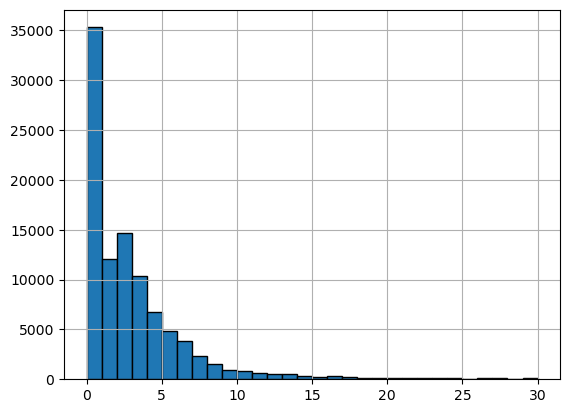

In [118]:
encdf2['lengthStay'].hist(bins=30, edgecolor='black')